In [1]:

from scipy.stats import pearsonr
import json
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

from Config import get_data_dir


In [2]:
main_dir = './Models'

# Collect the data for each training mode
data = {}
for mode_dir in glob.glob('{}/*'.format(main_dir)):
    mode = mode_dir.split('/')[-1]
    
    if mode != 'initial-transfer' and mode.split('-')[0] != 'partial': #Ignore the models we aren't analyzing
        # Aggregate the data for that mode across the trials
        data_mode = {}
        count = 0
        for trial_dir in glob.glob('{}/trial*'.format(mode_dir)):
            with open('{}/results.json'.format(trial_dir), 'r') as f:
                data_tmp = json.load(f)
            for key in data_tmp:
                if key in data_mode:
                    data_mode[key].append(data_tmp[key])
                else:
                    data_mode[key] = [data_tmp[key]]

        # We want the average
        for key in data_mode:
            data_tmp = data_mode[key]
            data_mode[key] = '{} ({})'.format(np.round(np.mean(data_tmp), 4), np.round(np.std(data_tmp), 4))

        # Compute aggregated accuracy metrics
        data[mode] = data_mode

# Convert the nested dictionary into a csv
modes = [key for key in data]
modes.sort()
metrics = [key for key in data[modes[0]]]

# Group the results by pair
with open('./FindSCs.json', 'r') as f:
    pairs = json.load(f)

metric_groups = {}
metric_groups['avg'] = [('MAP', 'MAP'), ('MAR', 'MAR')]

for pair in pairs:
    n = len(pair)
    main = pair.split('-')[0]
    spurious = pair.split('-')[1]
    n_main = len(main)
    tmp = []
    for metric in metrics:
        if metric[:n] == pair:
            name = metric[n+1:]
            tmp.append((name, metric))
    metric_groups[pair] = tmp

# Save the results
for group in metric_groups:

    df = pd.DataFrame()
    df['Mode'] = modes
    for info in metric_groups[group]:
        name = info[0]
        metric = info[1]
        data_tmp = []
        for mode in modes:
            data_tmp.append(data[mode][metric])
        df[name] = data_tmp

    df.to_csv('./Analysis/{}.csv'.format(group), index = False)

In [3]:
# Show the results for each object pair and then the aggregated differences

def remove_var_info(df):
    def remove(x):
        return x.split(' ')[0]
    return df.applymap(remove)

groups = {}
for pair in pairs:
    spurious = pair.split('-')[1]    
    if spurious in groups:
        groups[spurious].append(pair)
    else:
        groups[spurious] = [pair]

cols_acc = ['Mode', 'both', 'just_main', 'just_spurious', 'neither', 'b-precision', 'b-recall', 'r-gap', 'h-gap']
    
def compare(corrected, baseline):
    modes = [corrected, baseline]

    diffs_acc = {}
    for metric in cols_acc[1:]:
        diffs_acc[metric] = []
    
    stats = {}
    stats['P(M)'] = []
    stats['P(S)'] = []
    stats['bias'] = []

    for key in groups:
        group = groups[key]
        #print()
        #print()
        #print(key)
        #print()
        for pair in group:

            #print(pair)
                        
            with open('{}/train/splits/{}.json'.format(get_data_dir(), pair), 'r') as f:
                splits = json.load(f)
                
            for split in splits:
                splits[split] = len(splits[split])
            
            P_M = (splits['both'] + splits['just_main']) / (splits['both'] + splits['just_spurious'] + splits['just_main'] + splits['neither'])
            P_S = (splits['both'] + splits['just_spurious']) / (splits['both'] + splits['just_spurious'] + splits['just_main'] + splits['neither'])
            P_S_g_M = splits['both'] / (splits['both'] + splits['just_main'])  
            stats['P(M)'].append(P_M)
            stats['P(S)'].append(P_S)
            stats['bias'].append((P_S_g_M - P_S) / P_S)
            #print('P(M), P(S|M), P(S):', np.round(P_M, 3), np.round(P_S_g_M, 3), np.round(P_S, 3))
            
            df = pd.read_csv('./Analysis/{}.csv'.format(pair))

            #print('Acc Comparison')
            df_tmp = remove_var_info(df.loc[df['Mode'].isin(modes), cols_acc].copy())
            #print(df_tmp.to_string(index = False)) 

            for metric in diffs_acc:
                data_tmp = {}
                names = df_tmp['Mode'].values
                values = df_tmp[metric].values
                for i in range(len(names)):
                    data_tmp[names[i]] = float(values[i])
                if not np.any(data_tmp == -1):
                    diffs_acc[metric].append(data_tmp[modes[0]] - data_tmp[modes[1]])
            #print()
            #print()

    #print()
    #print()
    #print()
    #print()
    print('Aggregate Differences:')
    
    def get_stats(key, diffs):
        print(key)
        data = diffs[key]
        print('mean (std):', np.round(np.mean(data), 3), np.round(np.std(data), 3))
        print('median:', np.round(np.median(data), 3))
        if key in ['r-gap', 'h-gap']:
            print('prob < 0:',  np.round(np.mean(np.array(data) < 0), 3))
        else:
            print('prob > 0:',  np.round(np.mean(np.array(data) > 0), 3))
        print()
        print()

    for key in diffs_acc:
        plt.hist(diffs_acc[key], bins = 15)
        if key == 'b-precision':
            plt.title('Change in Balanced Precision')
        elif key == 'r-gap':
            plt.title('Change in Recall Gap')
        elif key == 'h-gap':
            plt.title('Change in Hallucination Gap')
        else:
            plt.title(key)
        plt.show()
        plt.close()
        get_stats(key, diffs_acc)
        
    weight = np.array(stats['P(S)']) * np.array(stats['P(M)'])
     
    fs = 20.0

    plt.scatter(weight, diffs_acc['b-precision'])
    plt.axhline(y=0, linestyle='dashed', c = 'black')
    plt.xlabel('P(Main) * P(Spurious)', fontsize = fs)
    plt.ylabel('Change in b-precision', fontsize = fs)
    plt.show()
    plt.close()
    
    plt.scatter(stats['bias'], diffs_acc['b-precision'])
    plt.axhline(y=0, linestyle='dashed', c = 'black')
    plt.xlabel('bias', fontsize = fs)
    plt.ylabel('Change in b-precision', fontsize = fs)
    plt.show()
    plt.close()
    
    plt.scatter(stats['bias'], weight)
    plt.xlabel('bias', fontsize = fs)
    plt.ylabel('P(Main) * P(Spurious)', fontsize = fs)
    plt.show()
    plt.close()


Aggregate Differences:


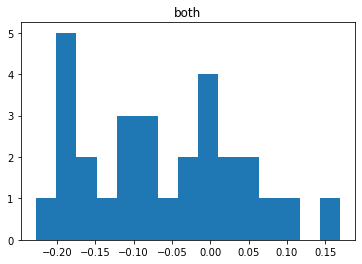

both
mean (std): -0.064 0.101
median: -0.073
prob > 0: 0.276




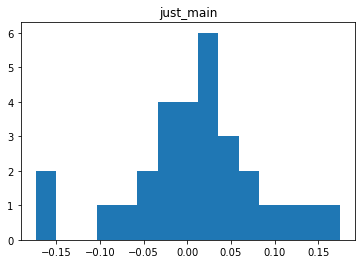

just_main
mean (std): 0.008 0.074
median: 0.013
prob > 0: 0.586




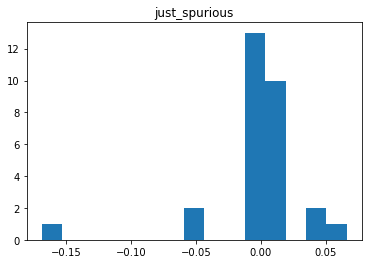

just_spurious
mean (std): -0.001 0.038
median: 0.003
prob > 0: 0.69




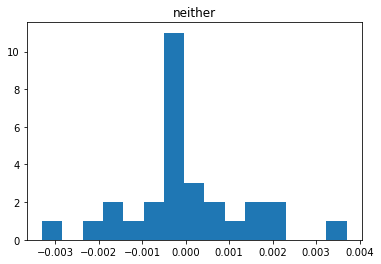

neither
mean (std): -0.0 0.001
median: -0.0
prob > 0: 0.379




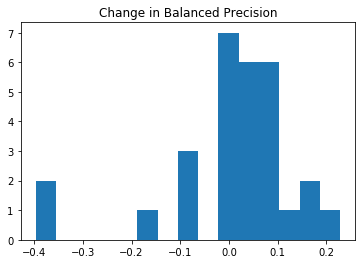

b-precision
mean (std): 0.012 0.135
median: 0.051
prob > 0: 0.724




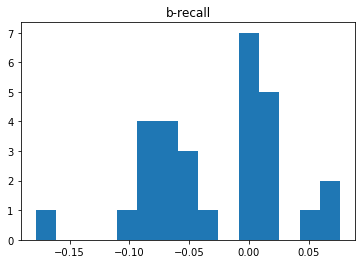

b-recall
mean (std): -0.028 0.055
median: -0.007
prob > 0: 0.31




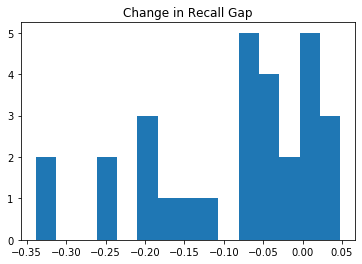

r-gap
mean (std): -0.09 0.108
median: -0.055
prob < 0: 0.759




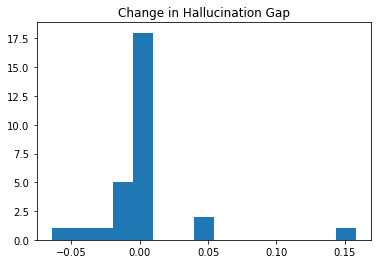

h-gap
mean (std): 0.001 0.036
median: -0.003
prob < 0: 0.759




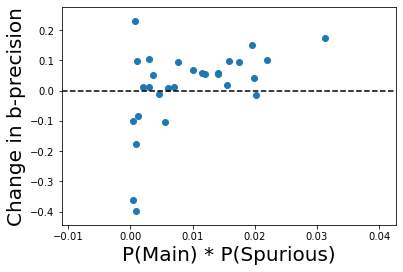

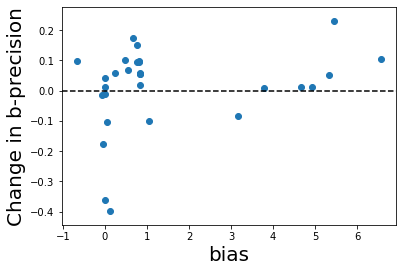

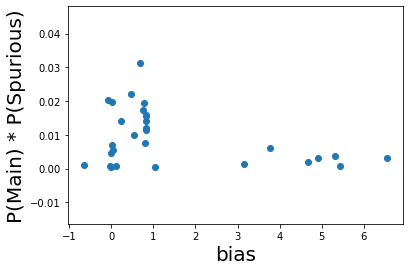

In [4]:
compare('auto-aug', 'initial-tune')

Aggregate Differences:


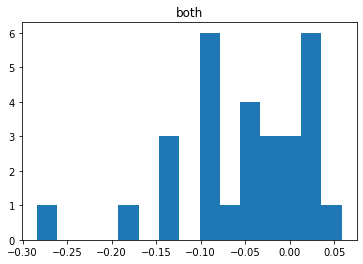

both
mean (std): -0.051 0.073
median: -0.035
prob > 0: 0.31




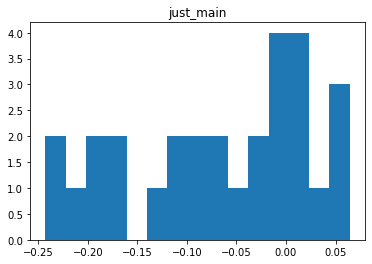

just_main
mean (std): -0.067 0.092
median: -0.056
prob > 0: 0.276




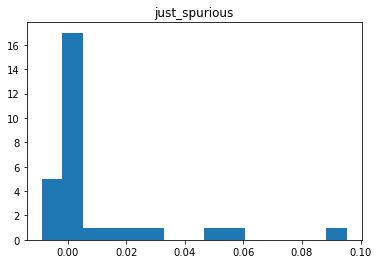

just_spurious
mean (std): 0.009 0.022
median: 0.001
prob > 0: 0.655




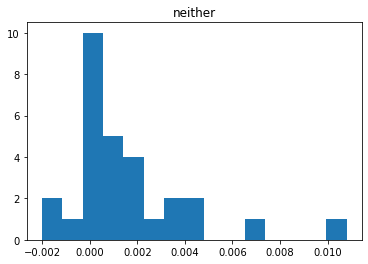

neither
mean (std): 0.002 0.003
median: 0.001
prob > 0: 0.552




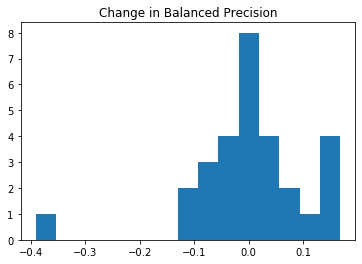

b-precision
mean (std): 0.006 0.106
median: 0.015
prob > 0: 0.621




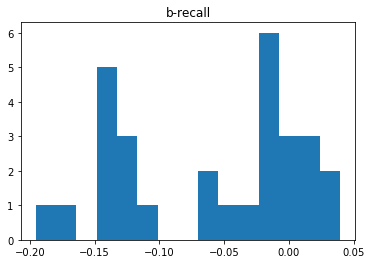

b-recall
mean (std): -0.059 0.069
median: -0.038
prob > 0: 0.276




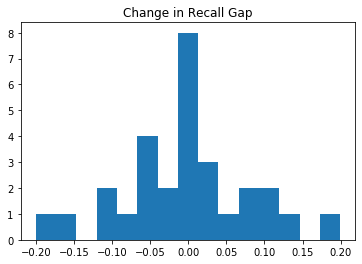

r-gap
mean (std): -0.004 0.083
median: -0.005
prob < 0: 0.552




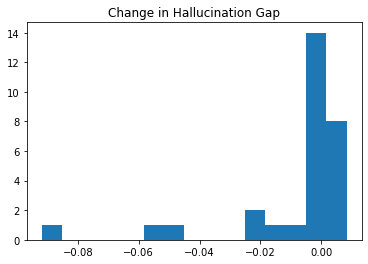

h-gap
mean (std): -0.008 0.021
median: -0.0
prob < 0: 0.586




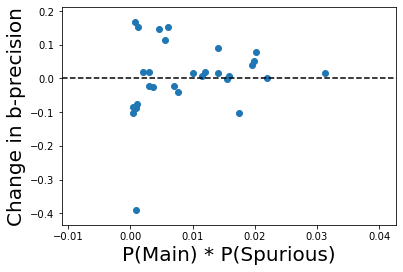

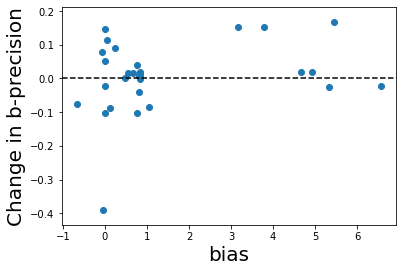

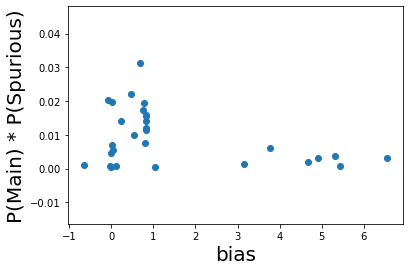

In [5]:
compare('fs-tune', 'initial-tune')

In [6]:
mode = 'fs-tune'
base = 'initial-tune'

mean = []
median = []
agg = []
for trial in [0, 1, 2, 3]:

    with open('./Models/{}/trial{}/results.json'.format(mode, trial), 'r') as f:
        data_mode = json.load(f)
        
    with open('./Models/{}/trial{}/results.json'.format(base, trial), 'r') as f:
        data_base = json.load(f)
        
    diffs = []          
    for pair in pairs:
        name = '{}-b-precision'.format(pair)
        diffs.append(data_mode[name] - data_base[name])
        
    mean.append(np.mean(diffs))
    median.append(np.median(diffs))
    agg.append(diffs)
    

agg = np.array(agg)
agg = np.mean(agg, axis = 0)


print('b-precision')
print(np.mean(agg), np.median(agg))
print(np.mean(mean), np.std(mean))
print(np.mean(median), np.std(median))


agg = []
for trial in [0, 1, 2, 3]:

    with open('./Models/{}/trial{}/results.json'.format(mode, trial), 'r') as f:
        data_mode = json.load(f)
        
    with open('./Models/{}/trial{}/results.json'.format(base, trial), 'r') as f:
        data_base = json.load(f)
        
    diffs = []          
    for pair in pairs:
        name = '{}-r-gap'.format(pair)
        diffs.append(1.0 * (data_mode[name] < data_base[name]))
        
    agg.append(np.mean(diffs))
        
print('r-gap')
print(np.mean(agg), np.std(agg))


agg = []
for trial in [0, 1, 2, 3]:

    with open('./Models/{}/trial{}/results.json'.format(mode, trial), 'r') as f:
        data_mode = json.load(f)
        
    with open('./Models/{}/trial{}/results.json'.format(base, trial), 'r') as f:
        data_base = json.load(f)
        
    diffs = []          
    for pair in pairs:
        name = '{}-h-gap'.format(pair)
        diffs.append(1.0 * (data_mode[name] < data_base[name]))
        
    agg.append(np.mean(diffs))
        
print('h-gap')
print(np.mean(agg), np.std(agg))
        


b-precision
0.005750077176881013 0.01497926086720866
0.005750077176881013 0.006117466784424308
0.01292831145591461 0.014630622840423223
r-gap
0.5 0.06216467716317222
h-gap
0.5258620689655171 0.051000687785341496


In [7]:

metric = 'h-gap' #'b-precision'

for mode in ['initial-tune', 'auto-aug', 'fs-tune']:
    print(mode)

    mean = []
    median = []
    agg = []
    for trial in [0, 1, 2, 3]:

        with open('./Models/{}/trial{}/results.json'.format(mode, trial), 'r') as f:
            data = json.load(f)

        results = []          
        for pair in pairs:
            name = '{}-{}'.format(pair, metric)
            v = data[name]
            if metric in ['r-gap', 'h-gap']:
                v = np.abs(v)
            results.append(v)

        mean.append(np.mean(results))
        median.append(np.median(results))
        agg.append(results)


    agg = np.array(agg)
    agg = np.mean(agg, axis = 0)


    print(np.mean(agg), np.median(agg))
    print(np.mean(mean), np.std(mean))
    print(np.mean(median), np.std(median))

        



initial-tune
0.024610263855238398 0.005470561928198864
0.0246102638552384 0.005323473598008298
0.005623074297475356 0.0011971815966769917
auto-aug
0.025202672311458955 0.0018872419077711755
0.02520267231145895 0.004709967790585222
0.0024934815279324674 0.0005464938964491657
fs-tune
0.016541566799576055 0.008284480558155338
0.01654156679957606 0.0023432851751154895
0.007402251221540146 0.001844767040838975


In [8]:
mode = 'fs-tune'
base = 'initial-tune'

mean = []
median = []
agg = []
for trial in [0, 1, 2, 3]:

    with open('./Models/{}/trial{}/results.json'.format(mode, trial), 'r') as f:
        data_mode = json.load(f)
        
    with open('./Models/{}/trial{}/results.json'.format(base, trial), 'r') as f:
        data_base = json.load(f)
        
    diffs = []          
    for pair in pairs:
        name = '{}-b-precision'.format(pair)
        diffs.append(data_mode[name] - data_base[name])
        
    mean.append(np.mean(diffs))
    median.append(np.median(diffs))
    agg.append(diffs)
    

agg = np.array(agg)
agg = np.mean(agg, axis = 0)


print('b-precision')
print(np.mean(agg), np.median(agg))
print(np.mean(mean), np.std(mean))
print(np.mean(median), np.std(median))


        



b-precision
0.005750077176881013 0.01497926086720866
0.005750077176881013 0.006117466784424308
0.01292831145591461 0.014630622840423223


In [9]:
meta = []

for pair in pairs:
    with open('{}/train/splits/{}.json'.format(get_data_dir(), pair), 'r') as f:
        splits = json.load(f)
        
    n = 0
    for key in splits:
        splits[key] = len(splits[key])
        n += splits[key]
        
    for key in splits:
        splits[key] /= n
        
    main = pair.split('-')[0].replace('+', ' ')
    spurious = pair.split('-')[1].replace('+', ' ')
    
    P_m = splits['both'] + splits['just_main']
    P_s = splits['both'] + splits['just_spurious']
    P_s_given_m = splits['both'] / P_m
    B = (P_s_given_m - P_s) / P_s
    R = splits['both'] / splits['just_main']
    
    P_m = np.round(P_m, 3)
    P_s = np.round(P_s, 3)
    P_s_given_m = np.round(P_s_given_m, 3)
    B = np.round(B, 3)
    R = np.round(R, 3)
    
    meta.append((main, spurious, P_m, P_s, P_s_given_m, B, R))
    
meta.sort(key = lambda x: x[5])



stdout_fileno = sys.stdout

sys.stdout = open('./Analysis/all.tex', 'w')
print('\\centering')
print('\\resizebox{\\linewidth}{!}{')
print('\\begin{tabular}{@{}lllllllll@{}}')
print('\\toprule')
print('Model& Both& Just Main& Just Spurious& Neither& B-Precision& B-Recall& Recall Gap& Hallucination Gap \\\\ \\midrule')

for info in meta:
        
    print('Main: {} & Spurious: {} & P(Main): {} & P(Spurious): {} & P(Spurious \\textbar Main): {} & Bias: {} & Ratio: {} & \\\\'.format(info[0], info[1], info[2], info[3], info[4], info[5], info[6]))
    
    pair = '{}-{}'.format(info[0], info[1]).replace(' ', '+')
    df = pd.read_csv('./Analysis/{}.csv'.format(pair))
    
    df.replace(['initial-tune'], 'Baseline', inplace = True)
    df.replace(['auto-aug'], 'SPIRE', inplace = True)
    
    for mode in ['Baseline', 'SPIRE']:
        row = ''
        for value in df.loc[df['Mode'] == mode].to_numpy()[0]:
            row += '{}&'.format(value)
        row = row[:-1]
        row += '\\\\'
        if mode == 'SPIRE':
            row += ' \\midrule'

        print(row)

print('\\end{tabular}}')
sys.stdout = stdout_fileno
    